In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
import tensorly as tl
from tensorly.decomposition import tucker 

Using numpy backend.


In [3]:
tf.enable_eager_execution()

Why is this hard to think about!?

Want to find temporally abstract patterns between observations, actions and rewards.

In [56]:
env = gym.make('LunarLander-v2')
# env = gym.make('Pong-v0')

In [57]:
def play_episode(player, env, len_episode=100):
    obs = env.reset()
    trajectory = []
    old_obs = obs
    done = False
    
    # need fixed length trajectories
    for _ in range(len_episode):
        if not done:
            a = player(obs)
            obs, r, done, info = env.step(a)
            
        else:  # pad with zeros
            a = 0
            obs, r, done, info = (np.zeros(obs.size), 0, done, None)

        trajectory.append(np.concatenate([np.array([a]), old_obs.ravel(), np.array([r])]))
        old_obs = obs
    return np.vstack(trajectory)

In [58]:
# plt.imshow(env.reset()[::4, ::4, :])

In [59]:
len_episode = 50
n_actions = env.action_space.n
n_possible_trajectories = n_actions**len_episode
print('Total possible trajectories = {}'.format(n_possible_trajectories))

Total possible trajectories = 1267650600228229401496703205376


In [60]:
trajectory = play_episode(lambda *args: env.action_space.sample(), env, len_episode)

In [63]:
def generate_data(n_episodes, len_episodes):
    # generate dataset using rnd policy
    dataset = np.stack([play_episode(lambda *args: env.action_space.sample(), env, len_episode)
                          for _ in range(n_episodes)], axis=0)
    return dataset  # N x len x [a, obs, r]

dataset = generate_data(1000, 50)

In [64]:
dataset.shape

(1000, 50, 10)

In [65]:
def batch_to_options(dataset, n_actions_in_option):
    # get all combinations of actions to 
    # eval the options we have data for
    
    # in: batch x len x [a, obs, r] 
    # out: traj x option x [a,obs, r]
    B, L, D = dataset.shape
    out = tf.extract_image_patches(
        np.reshape(dataset, [B, 1, L, D]), 
        ksizes=[1,1,n_actions_in_option,1], 
        strides=[1,1,1,1], 
        rates=[1,1,1,1], 
        padding="SAME").numpy()
    out = np.reshape(out, [B*L, n_actions_in_option, D])
    return out

In [66]:
actions = batch_to_options(dataset[:,:-1,0:1], 3)
actions.shape
actions = tf.constant(actions, dtype=tf.int32)
actions = tf.one_hot(actions, axis=-1, depth=4, off_value=0.0,on_value=1.0)
actions = actions.numpy()
actions = np.reshape(actions, [actions.shape[0], -1])
actions.shape

(49000, 12)

In [67]:
obs = batch_to_options(dataset[:,1:,1:] - dataset[:,:-1,1:], 3)
obs = np.reshape(obs, [obs.shape[0], -1])
obs.shape

(49000, 27)

In [68]:
corr = np.cov(actions.T, obs.T)
# plt.imshow(np.sqrt(np.abs(corr)), interpolation='nearest', cmap='gray')

In [69]:
u, s, v = np.linalg.svd(corr)

<BarContainer object of 39 artists>

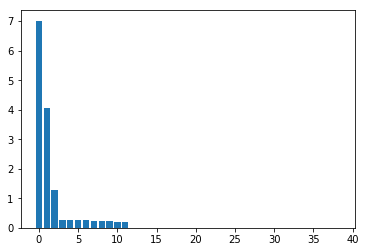

In [70]:
plt.bar(range(len(s)), s)

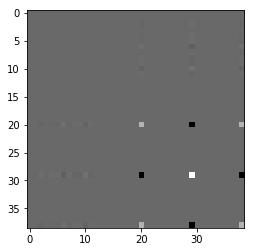

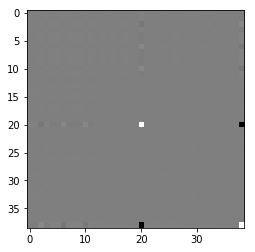

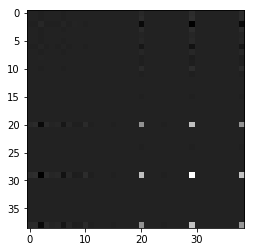

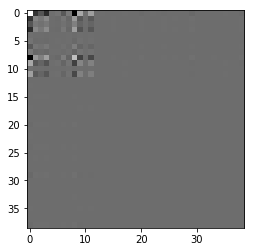

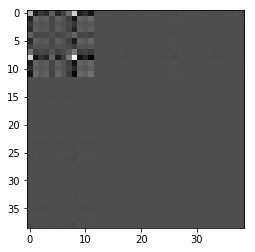

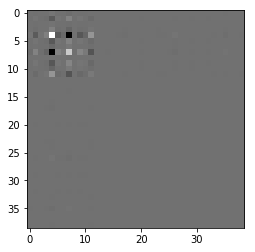

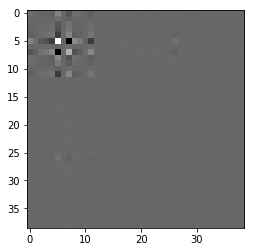

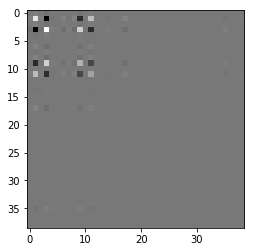

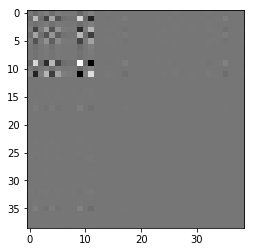

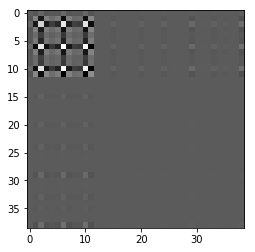

In [71]:
for i in range(10):
    # these are not interpretable... want to use atari. but obs space is too big...
    D = np.zeros([u.shape[0], v.shape[0]])
    D[i,i] = s[i]
    rankoneproj = np.dot(np.dot(u, D), v)
    plt.figure()
    plt.imshow(rankoneproj, interpolation='nearest', cmap='gray')

In [72]:
corr.shape

(39, 39)